In [2]:
## Step 0 - Parameters and Libraries

import DrainMethod
import sys
import os

## General parameters 

input_dir = os.path.join(os.getcwd(), "logs") # The input directory of raw logs
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
#logName = 'Ciena_error_lin0es_20220701-20220715.txt' # Name of file to be parsed
#logName = 'ciena-mini.txt' # Name of file to be parsed
logName = 'Andriod_2k.log' # Name of file to be parsed
log_format = '<Content>' # Format of the file, if there are different fields
regex = [] # Regex strings for Drain execution

In [3]:
## Step 1 - Log Parsing Using Drain

## Drain parameters

st = 0.5 # Drain similarity threshold
depth = 5 # Max depth of the parsing tree

## Code

print('\n=== Starting Drain Parsing ===')
indir = os.path.join(input_dir, os.path.dirname(logName))
print(indir)
log_file = os.path.basename(logName)

parser = DrainMethod.LogParser(log_format=log_format, indir=indir, outdir=output_dir, rex=regex, depth=depth, st=st)
parser.parse(log_file)

parsedresult=os.path.join(output_dir, log_file + '_structured.csv')   


=== Starting Drain Parsing ===
/home/vbertalan/Downloads/CSL-1/CSL/logs/
Parsing file: /home/vbertalan/Downloads/CSL-1/CSL/logs/Andriod_2k.log


Parsing Progress: 100%|██████████| 2000/2000 [00:00<00:00, 17558.65it/s]


Parsing done. [Time taken: 0:00:00.361052]


In [12]:
# ## Step 2 - Embedding Creation Using Transformers

# from sentence_transformers import SentenceTransformer
# from pathlib import Path
# import pandas as pd
# import regex as re
# import contextlib
# import pickle

# ## General Parameters

# vector_dir = os.path.join(os.getcwd(), "vectors")  # The vector directory of converted logs
# indir = os.path.join(input_dir, os.path.dirname(logName)) # Input directory

# ## Code

# # Function to generate regular expression to split log messages
# def generate_logformat_regex(log_format):
#     headers = []
#     splitters = re.split(r'(<[^<>]+>)', log_format)
#     regex = ''
#     for k in range(len(splitters)):
#         if k % 2 == 0:
#             splitter = re.sub(' +', '\\\s+', splitters[k])
#             regex += splitter
#         else:
#             header = splitters[k].strip('<').strip('>')
#             regex += f'(?P<{header}>.*?)'
#             headers.append(header)
#     regex = re.compile('^' + regex + '$')
#     return headers, regex

# # Function to transform log file to dataframe 
# def log_to_dataframe(log_file, regex, headers, logformat):
#     log_messages = []
#     linecount = 0
#     with open(log_file, 'r') as fin:
#         for line in fin.readlines():
#             with contextlib.suppress(Exception):
#                 match = regex.search(line.strip())
#                 message = [match.group(header) for header in headers]
#                 log_messages.append(message)
#                 linecount += 1
#     logdf = pd.DataFrame(log_messages, columns=headers)
#     logdf.insert(0, 'LineId', None)
#     logdf['LineId'] = [i + 1 for i in range(linecount)]
#     return logdf

# # Preprocesses dataframe with regexes, if necessary - more preprocessing to add
# def preprocess_df(df_log):
#     for idx, content in df_log["Content"].items():
#         for currentRex in regex:
#             df_log.at[idx,'Content'] = re.sub(currentRex, '<*>', content)
#     return df_log

# # Calls conversion from data to dataframe
# def load_data():
#     headers, regex = generate_logformat_regex(log_format)
#     return log_to_dataframe(os.path.join(indir, logName), regex, headers, log_format)

# # Transforms the dataset, creating raw vector file
# def transform_dataset(raw_content):
    
#     path_to_file = os.path.join(vector_dir, logName + '_vectors.vec')
#     path = Path(path_to_file)
#     vectors = []

#     if (path.is_file()):
#         vectors = pickle.load(open(path_to_file, 'rb'))
#         print(type(vectors))
#     else:
#         # Using standard MPNet transformer
#         model = SentenceTransformer('all-mpnet-base-v2')
#         print("Iniciando encode")
#         vectors = model.encode(raw_content)
#         print(type(vectors))
#         pickle.dump(vectors, open(path_to_file, 'wb'))
    
#     return vectors

# # Creates embeddings for log file
# def transform(logName):
#     print('Transforming file: ' + os.path.join(input_dir, logName))
#     log_df = load_data()
#     log_df = preprocess_df(log_df)
#     return transform_dataset(log_df["Content"])

# vector_mat = transform(os.path.basename(logName))


In [4]:
## Step 2.1 - Vector Creation Using TFIDF

from sklearn.feature_extraction.text import TfidfVectorizer
from pathlib import Path
import pandas as pd
import regex as re
import contextlib
import pickle

# Calls conversion from data to dataframe
def load_data():
    headers, regex = generate_logformat_regex(log_format)
    return log_to_dataframe(os.path.join(indir, logName), regex, headers, log_format)

# Preprocesses dataframe with regexes, if necessary - more preprocessing to add
def preprocess_df(df_log):
    for idx, content in df_log["Content"].items():
        for currentRex in regex:
            df_log.at[idx,'Content'] = re.sub(currentRex, '<*>', content)
    return df_log

# Function to generate regular expression to split log messages
def generate_logformat_regex(log_format):
    headers = []
    splitters = re.split(r'(<[^<>]+>)', log_format)
    regex = ''
    for k in range(len(splitters)):
        if k % 2 == 0:
            splitter = re.sub(' +', '\\\s+', splitters[k])
            regex += splitter
        else:
            header = splitters[k].strip('<').strip('>')
            regex += f'(?P<{header}>.*?)'
            headers.append(header)
    regex = re.compile('^' + regex + '$')
    return headers, regex

# Function to transform log file to dataframe 
def log_to_dataframe(log_file, regex, headers, logformat):
    log_messages = []
    linecount = 0
    with open(log_file, 'r') as fin:
        for line in fin.readlines():
            with contextlib.suppress(Exception):
                match = regex.search(line.strip())
                message = [match.group(header) for header in headers]
                log_messages.append(message)
                linecount += 1
    logdf = pd.DataFrame(log_messages, columns=headers)
    logdf.insert(0, 'LineId', None)
    logdf['LineId'] = [i + 1 for i in range(linecount)]
    return logdf

# Transforms the dataset, creating raw vector file
def transform_dataset(raw_content):
    
    path_to_file = os.path.join(vector_dir, logName + '_vectors_TFIDF.vec')
    path = Path(path_to_file)
    vectors_tfidf = []

    if (path.is_file()):
        vectors_tfidf = pickle.load(open(path_to_file, 'rb'))
    else:
        # Using TFIDF Vectorizer 
        print("Iniciando encode")
        tr_idf_model  = TfidfVectorizer()
        vectors_tfidf = tr_idf_model.fit_transform(raw_content)
        pickle.dump(vectors_tfidf, open(path_to_file, 'wb'))
    
    print(type(vectors_tfidf))
    return vectors_tfidf

# Creates embeddings for log file
def transform(logName):
    print('Transforming file: ' + os.path.join(input_dir, logName))
    log_df = load_data()
    log_df = preprocess_df(log_df)
    return transform_dataset(log_df["Content"])

vector_df = transform(os.path.basename(logName))

Transforming file: /home/vbertalan/Downloads/CSL-1/CSL/logs/Andriod_2k.log
<class 'scipy.sparse._csr.csr_matrix'>


In [11]:
## Vendo detalhes com matriz normal

# print(type(vector_mat))
# print("O número de linhas do arquivo transformado é {}".format(len(vector_mat)))
# print("O número de colunas do arquivo transformado é {}".format(len(vector_mat[0])))
# print(vector_mat[2][1])
# print(vector_mat[0][0])

In [5]:
## Vendo detalhes de matriz esparsa

print(type(vector_df))
print(vector_df.shape)
print("O número de linhas do arquivo transformado é {}".format(vector_df.shape[0]))
print("O número de colunas do arquivo transformado é {}".format(vector_df.shape[1]))

<class 'scipy.sparse._csr.csr_matrix'>
(2000, 1670)
O número de linhas do arquivo transformado é 2000
O número de colunas do arquivo transformado é 1670


In [6]:
## Step 3 - Creates matrix of parsed items

from sklearn.preprocessing import MultiLabelBinarizer
from ast import literal_eval
import pandas as pd 

## General Parameters

output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

## Code

# Reads parameters list
full_df = pd.read_csv(output_csv)
var_df = full_df["ParameterList"]

# Breaks the string into lists
for i, line in var_df.items():
    var_df.at[i] = literal_eval(var_df.at[i])

# Transforms variables list to variable matrix
#mlb = MultiLabelBinarizer()
#var_df = pd.DataFrame(mlb.fit_transform(var_df),columns=mlb.classes_)
#print ("A matrix parseada de variaveis tem o formato {}".format(var_df.shape))

# Transforms variable list to variable SPARSE matrix
mlb = MultiLabelBinarizer(sparse_output=True)
var_df = mlb.fit_transform(var_df)
print ("A matrix parseada de variaveis tem o formato {}".format(var_df.shape))
print(type(var_df))

A matrix parseada de variaveis tem o formato (2000, 1839)
<class 'scipy.sparse._csr.csr_matrix'>


In [9]:
# ## Step 4 - Concatenates Embeddings Matrix with Variables Matrix Using Numpy

# import numpy as np

# var_mat = var_df.to_numpy()

# print("A matrix de vetores tem {} linhas".format(len(vector_mat)))
# print("A matrix de vetores tem {} colunas".format(len(vector_mat[0])))
# print("A matrix de variaveis tem {} linhas".format(len(var_mat)))
# print("A matrix de variaveis tem {} colunas".format(len(var_mat[0])))

# concat_mat = np.hstack((vector_mat,var_mat))

# print("A matrix concatenada tem {} linhas".format(len(concat_mat)))
# print("A matrix concatenada tem {} colunas".format(len(concat_mat[0])))

# np.savetxt("concat_mat_numpy.csv", concat_mat, delimiter=";")


A matrix de vetores tem 2000 linhas
A matrix de vetores tem 768 colunas
A matrix de variaveis tem 2000 linhas
A matrix de variaveis tem 1839 colunas
A matrix concatenada tem 2000 linhas
A matrix concatenada tem 2607 colunas


In [44]:
## Alternate Step 4 - Concatenates Embeddings Matrix with Variables Matrix Using Pandas

# # Com Transformers
# #vector_df = pd.DataFrame(vector_mat, columns = None)
# # Com TFIDF
# vector_df = pd.DataFrame(vector_mat.toarray(), columns = None)

# print("A matrix de vetores tem formato {}".format(vector_df.shape))
# print("A matrix de variaveis tem formato {}".format(var_df.shape))

# concat_df = pd.concat([vector_df, var_df], axis=1)

# print("A matrix de variaveis tem formato {}".format(concat_df.shape))

# # Saves concatenated matrix
# #concat_df.to_csv("concat_df_pandas.csv")

A matrix de vetores tem formato (2000, 1670)
A matrix de variaveis tem formato (2000, 1839)
A matrix de variaveis tem formato (2000, 3509)


In [15]:
# from sklearn.metrics.pairwise import pairwise_distances 
# import numpy as np

# a = [[0,0,0,1,1],
#      [1,1,1,1,1]]
# arr_a = np.array(a)

# b = [[1,1,1,1,0],
#      [1,1,1,1,1]]
# arr_b = np.array(b)

# print(pairwise_distances(arr_a,arr_b, metric="jaccard", n_jobs=-1))

In [20]:
# Step 5 - Creates distance matrix 

from sklearn.metrics.pairwise import pairwise_distances 
import numpy as np

# def jaccard_score(mat):
#     cols_sum = mat.getnnz(axis=1)
#     ab = mat * mat.T

#     # for rows
#     aa = np.repeat(cols_sum, ab.getnnz(axis=1))
#     # for columns
#     bb = cols_sum[ab.indices]

#     similarities = ab.copy()
#     similarities.data = (similarities.data) / (aa + bb - ab.data)

#     return similarities

# Using Euclidean Distance between the rows of the TFIDF Matrix
tfidf_distance = pairwise_distances(vector_df, metric="euclidean", n_jobs=-1)
#Normalizes Distance Matrix with Min-Max
min_val = np.min(tfidf_distance)
max_val = np.max(tfidf_distance)
tfidf_distance = (tfidf_distance - min_val) / (max_val - min_val)
print("As dimensões da matriz de embeddings são {}".format(tfidf_distance.shape))

# Using Jaccard Distance between the rows of the Variable Matrix
var_distance = pairwise_distances(np.asarray(var_df.todense()), metric="jaccard", n_jobs=-1)
print("As dimensões da matriz de variáveis são {}".format(var_distance.shape))

# Creates Count Matrix using line numbers from log lines as the counter
count_list = []
n = len(tfidf_distance)
count_distance = np.zeros(shape=(n, n), dtype=int)
for i in range(n):
        count_list.append(i)

# Using a Subtraction Distance using the line numbers as a Count Matrix
count_array = np.array(count_list)
for x in count_array:
  for y in count_array:
    count_distance[x,y] = abs(x-y)
# Normalizes Distance Matrix with Min-Max
min_val = np.min(count_distance)
max_val = np.max(count_distance)
count_distance = (count_distance - min_val) / (max_val - min_val)
print("As dimensões da matriz de contadores são {}".format(count_distance.shape))

# Using alpha to define the weight of the TFIDF Matrix,  Beta to define the weight of the Variable Matrix,
# and Gamma to define the weight of the Count Matrix
alpha = 0.8
beta = 0.1
gamma = 0.1

if alpha+beta+gamma > 1:
   raise Exception("Valores devem somar 1!")

# New matrices, corrected by the weights
tfidf_distance = np.dot(alpha,tfidf_distance)
var_distance = np.dot(beta, var_distance)
count_distance = np.dot(gamma, var_distance)

# Sums remaining matrices
distance_matrix = np.asarray(tfidf_distance + var_distance + count_distance)

As dimensões da matriz de embeddings são (2000, 2000)


/home/vbertalan/anaconda3/lib/python3.9/site-packages/sklearn/metrics/pairwise.py:1875: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


As dimensões da matriz de variáveis são (2000, 2000)
As dimensões da matriz de contadores são (2000, 2000)


In [19]:
count = 0

#for line in distance_matrix:
    
linha = var_distance[0]
linha_ordenada = np.sort(linha, axis=None) 
print(linha_ordenada[300])


1.0


In [32]:
## Step 5 - Clustering with HDBScan Using Pre-defined Distance Matrix

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

# min_cluster_size:int, optional (default=5)
# The minimum size of clusters; single linkage splits that contain fewer points than this will 
# be considered points “falling out” of a cluster rather than a cluster splitting into two new clusters.

# min_samples:int, optional (default=None)
# The number of samples in a neighbourhood for a point to be considered a core point.

# p :int, optional (default=None)
# p value to use if using the minkowski metric.

# alpha :float, optional (default=1.0)
# A distance scaling parameter as used in robust single linkage. See [3] for more information.

# cluster_selection_epsilon: float, optional (default=0.0)
# A distance threshold. Clusters below this value will be merged.
# See [5] for more information.

# algorithm :string, optional (default=’best’)
# Exactly which algorithm to use; hdbscan has variants specialised for different characteristics 
# of the data. By default this is set to best which chooses the “best” algorithm given the nature 
# of the data. You can force other options if you believe you know better. Options are: 'best',
# 'generic', 'prims_kdtree', 'prims_balltree', 'boruvka_kdtree' and 'boruvka_balltree'

# leaf_size: int, optional (default=40)
# If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. 
# This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.

# cluster_selection_method :string, optional (default=’eom’)
# The method used to select clusters from the condensed tree. The standard approach for HDBSCAN is 
# to use an Excess of Mass algorithm to find the most persistent clusters. Alternatively you can 
# instead select the clusters at the leaves of the tree – this provides the most fine grained and 
# homogeneous clusters. Options are: 'eom' and 'leaf'

# allow_single_cluster :bool, optional (default=False)
# By default HDBSCAN will not produce a single cluster, setting this to True will override this 
# and allow single cluster results in the case that you feel this is a valid result for your dataset.

## Clusters with HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=5,min_samples=None,metric='precomputed',
                            cluster_selection_epsilon=0.1, alpha=1.0, leaf_size=40, 
                            allow_single_cluster=False,cluster_selection_method='eom',
                            gen_min_span_tree=True)


clusterer.fit(distance_matrix)

print ("O numero de clusters e {}".format(clusterer.labels_.max()))
print ("Os clusters de cada elemento são {}".format(clusterer.labels_))

## Checks number of outliers
cont = np.count_nonzero(clusterer.labels_ == -1)

print("O número de outliers é {}".format(cont))
print("O número de total de elementos é {}".format(len(clusterer.labels_)))

O numero de clusters e 9
Os clusters de cada elemento são [8 8 9 ... 3 3 3]
O número de outliers é 275
O número de total de elementos é 2000


In [79]:
## HDBSCAN - Naive grid search implementation by Mueller and Guido, Introduction to Machine Learning with Python

best_score = len(distance_matrix)

for min_cluster_size in [5,10,20,30]:
    for min_samples in [None,10,20,30]:
        for cluster_selection_method in ['leaf','eom',]:
            for cluster_selection_epsilon in [0.0,0.5,1.0]:
                # For each combination of parameters of HDBSCAN
                hdb = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size,min_samples=min_samples,
                                      cluster_selection_method=cluster_selection_method, 
                                      metric='precomputed',).fit(distance_matrix)
                # Calculates the outlier score
                score = np.count_nonzero(hdb.labels_ == -1)
                # if we got a smaller outlier score, store it and the parameters
                if score < best_score:
                    best_score = score
                    best_parameters = {'min_cluster_size': min_cluster_size, 
                               ' min_samples':  min_samples, 'cluster_selection_method': cluster_selection_method,
                               'cluster_selection_epsilon': cluster_selection_epsilon}

print("Smallest number of outliers: {}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Smallest number of outliers: 486
Best parameters: {'min_cluster_size': 5, ' min_samples': None, 'cluster_selection_method': 'eom', 'cluster_selection_epsilon': 0.0}


In [30]:
## Step 5 - Clustering with DBSCAN Using Pre-defined Distance Matrix

from sklearn.cluster import DBSCAN

# eps:float, default=0.5
# The maximum distance between two samples for one to be considered as in the neighborhood of the other. 
# This is not a maximum bound on the distances of points within a cluster. 
# This is the most important DBSCAN parameter to choose appropriately for your data set and distance function.

# min_samples:int, default=5
# The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself. If min_samples is set to a higher value, DBSCAN will find denser clusters, whereas if it is set to a lower value, the found clusters will be more sparse.

# algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}, default=’auto’
# The algorithm to be used by the NearestNeighbors module to compute pointwise distances and find nearest neighbors. See NearestNeighbors module documentation for details.

# leaf_size:int, default=30
# Leaf size passed to BallTree or cKDTree. This can affect the speed of the construction and query, as well as the memory required to store the tree. The optimal value depends on the nature of the problem.

# p:float, default=None
# The power of the Minkowski metric to be used to calculate distance between points. If None, then p=2 (equivalent to the Euclidean distance).

# n_jobs:int, default=None
# The number of parallel jobs to run. None means 1 unless in a joblib.parallel_backend context. -1 means using all processors. See Glossary for more details.

clusterer = DBSCAN(eps=0.7,min_samples=2,metric='precomputed',algorithm='auto',leaf_size=30,n_jobs=-1)
clusterer.fit(distance_matrix)

print ("O numero de clusters e {}".format(clusterer.labels_.max()))
print ("Os clusters de cada elemento são {}".format(clusterer.labels_))

## Checks number of outliers
cont = np.count_nonzero(clusterer.labels_ == -1)

print("O número de outliers é {}".format(cont))
print("O número de total de elementos é {}".format(len(clusterer.labels_)))

O numero de clusters e 46
Os clusters de cada elemento são [0 1 1 ... 4 4 4]
O número de outliers é 12
O número de total de elementos é 2000


In [29]:
## DBSCAN - Naive grid search implementation by Mueller and Guido, Introduction to Machine Learning with Python

best_score = len(distance_matrix)

for eps in [0.1, 0.2, 0.5, 0.7, 1, 1.5]:
    for min_samples in [2, 5,10,20,30,40,50]:
        for leaf_size in [5, 10, 20, 30, 40]:
                # For each combination of parameters of DBSCAN
                db = DBSCAN(eps=eps,min_samples=min_samples,leaf_size=leaf_size, 
                            metric='precomputed',n_jobs=-1).fit(distance_matrix)
                # Calculates the outlier score
                score = np.count_nonzero(db.labels_ == -1)
                # if we got a smaller outlier score, store it and the parameters
                if db.labels_.max() != 0 and score < best_score:
                    best_score = score
                    best_parameters = {'eps': eps, 
                               ' min_samples':  min_samples, 'leaf_size': leaf_size,}

print("Smallest number of outliers: {}".format(best_score))
print("Best parameters: {}".format(best_parameters))

Smallest number of outliers: 12
Best parameters: {'eps': 0.7, ' min_samples': 2, 'leaf_size': 5}


/home/vbertalan/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/vbertalan/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/vbertalan/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


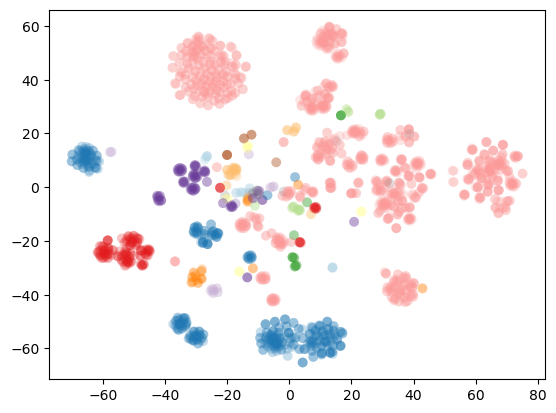

In [31]:
## Plots results

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

projection = TSNE(metric='precomputed').fit_transform(distance_matrix)

color_palette = sns.color_palette('Paired', clusterer.labels_.max()+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

In [49]:
# ## Step 5 - Clustering with HDBScan Using Pre-defined Distance Matrix

# import hdbscan

# clusterer = hdbscan.HDBSCAN()
# clusterer = hdbscan.HDBSCAN(min_cluster_size=50,min_samples=1,metric='precomputed',
#                             allow_single_cluster=False,cluster_selection_method='leaf')
# clusterer.fit(distance_matrix)
# cluster_num = clusterer.labels_.max()
# print ("O numero de clusters e {}".format(cluster_num))
# cluster_labels = clusterer.labels_
# print ("Os clusters de cada elemento sao {}".format(cluster_labels))

O numero de clusters e 11
Os clusters de cada elemento sao [-1  0  5 ...  8  8  8]


In [18]:
# ## Step 5 - Clustering with HDBScan

# import hdbscan

# clusterer = hdbscan.HDBSCAN()
# clusterer = hdbscan.HDBSCAN(min_cluster_size=50,min_samples=1,metric='euclidean',
#                             allow_single_cluster=False,cluster_selection_method='leaf')
# clusterer.fit(concat_df)
# cluster_num = clusterer.labels_.max()
# print ("O numero de clusters e {}".format(cluster_num))
# cluster_labels = clusterer.labels_
# print ("Os clusters de cada elemento sao {}".format(cluster_labels))

O numero de clusters e 8
Os clusters de cada elemento sao [ 7  7 -1 ...  8  8  8]


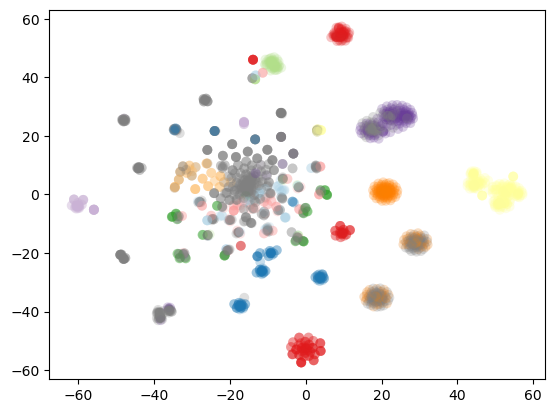

In [41]:
## Step 6 - Plotting with TSNE

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

#concat_df.columns = concat_df.columns.astype(str)
projection = TSNE(metric='precomputed').fit_transform(distance_matrix)
#plt.scatter(*projection.T, **plot_kwds)

color_palette = sns.color_palette('Paired', cluster_num+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [50]:
## Step 7 - Checks number of outliers

cont = 0

for elem in clusterer.labels_:
   if (elem == -1):
      cont += 1

print("O número de outliers é {}".format(cont))
print("O número de total de elementos é {}".format(len(clusterer.labels_)))

O número de outliers é 627
O número de total de elementos é 2000


In [76]:
## Step 8 - Normalizes Embeddings

from sklearn.preprocessing import MinMaxScaler

# Normaliza entre 0 e 0.5
scaler = MinMaxScaler((0,0.75))

# Normaliza df de embeddings
vector_df = pd.DataFrame(vector_mat, columns = None)
vector_scaling = scaler.fit_transform(vector_df)
vector_df = pd.DataFrame(vector_scaling, columns = None)

# Concatena com o df de variaveis
concat_df = pd.concat([vector_df, var_df], axis=1)

O numero de clusters e 17
Os clusters de cada elemento sao [12 16 16 ...  5  4  3]


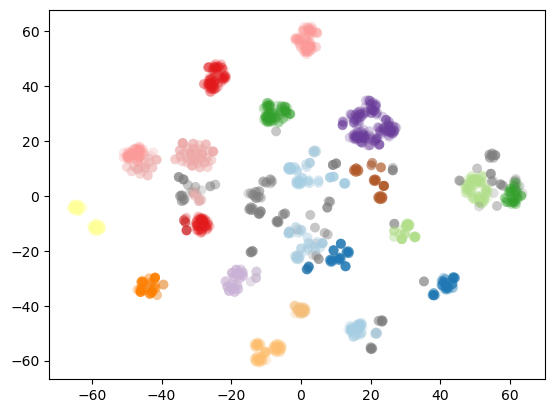

In [74]:
## Step 9 - Plots again, after normalization 

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan

clusterer = hdbscan.HDBSCAN()
clusterer = hdbscan.HDBSCAN(min_cluster_size=50,min_samples=1,metric='euclidean',
                            allow_single_cluster=False,cluster_selection_method='leaf')

concat_df.columns = concat_df.columns.astype(str)
clusterer.fit(concat_df)
cluster_num = clusterer.labels_.max()
print ("O numero de clusters e {}".format(cluster_num))
cluster_labels = clusterer.labels_
print ("Os clusters de cada elemento sao {}".format(cluster_labels))

projection = TSNE().fit_transform(concat_df)
#plt.scatter(*projection.T, **plot_kwds)

color_palette = sns.color_palette('Paired', cluster_num+1)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_member_colors, alpha=0.25)

In [75]:
## Step 10 - Checks number of outliers again

cont = 0

for elem in clusterer.labels_:
   if (elem == -1):
      cont += 1

print("O número de outliers é {}".format(cont))
print("O número de total de elementos é {}".format(len(clusterer.labels_)))

O número de outliers é 267
O número de total de elementos é 2000


In [51]:
## Step 11 - Creates a list of lists representing the clusters

import numpy as np

## General Parameters

cluster_idxs = []
cluster_lines = []
output_dir = os.path.join(os.getcwd(), "results")  # The output directory of parsing results
output_csv = os.path.join(output_dir, log_file + '_structured.csv') 

## Code

# Reads parameters list
full_df = pd.read_csv(output_csv)
elem_df = full_df["Content"]

# Creates blank lists
for elem in range (clusterer.labels_.max()+1):
    cluster_idxs.append([])
    cluster_lines.append([])

# Populate the lists with cluster elements
for idx, elem in np.ndenumerate(clusterer.labels_):
  if elem != -1:
    cluster_idxs[elem].append(idx[0])
    cluster_lines[elem].append(elem_df[idx[0]])

# Check sizes of each cluster
#for i in range(len(cluster_idxs)):
#   print(len(cluster_idxs[i]))

print(cluster_lines[10][9])



03-17 16:13:46.291  2227  2227 I StackScrollAlgorithm: updateDimmedActivatedHideSensitive overlap:true


In [54]:
## Step 12 - Eliminates stopwords on each cluster

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
import gensim.corpora as corpora
from pprint import pprint
import gensim
import nltk

# Parameters
#nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Converts sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

# Removes stopwords from each sentence
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]

# Finds topics of a given cluster
def find_topics(cluster_list, cluster_number, num_topics):
    # Converts to words
    data_words = list(sent_to_words(cluster_list[cluster_number]))
    # Removes stop words - OPTIONAL
    #data_words = remove_stopwords(data_words)
    # Creates dictionary
    id2word = corpora.Dictionary(data_words)
    # Creates corpora
    corpus = [id2word.doc2bow(text) for text in data_words]
    # Builds LDA model
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
    # Prints topics
    pprint(lda_model.print_topics())
    pprint(lda_model.get_topic_terms(0))
    return lda_model

topics = find_topics(cluster_lines, 4, 1)

# Gets word topics
x = topics.show_topics(num_topics=1, num_words=10,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Prints only the topics
for topic,words in topics_words:
    print(words)

for topic,words in topics_words:
    print(str(topic)+ "::"+ str(words))

#Below Code Prints Only Words 
for topic,words in topics_words:
    print (" ".join(words))

[(0,
  '0.249*"suspend" + 0.249*"blocker" + 0.249*"wakelocks" + 0.126*"releasing" + '
  '0.126*"acquiring"')]
[(2, 0.24907063),
 (0, 0.24907057),
 (3, 0.24907057),
 (1, 0.12639412),
 (4, 0.12639406)]
['suspend', 'blocker', 'wakelocks', 'releasing', 'acquiring']
0::['suspend', 'blocker', 'wakelocks', 'releasing', 'acquiring']
suspend blocker wakelocks releasing acquiring


In [55]:
## Step 13 - Finds most similar line inside the cluster to the words of the topic

from nltk.tokenize import WhitespaceTokenizer

tk = WhitespaceTokenizer()

def find_similar_lines(cluster_list, cluster_number, word_list):
    closest_line = 0
    similar_tokens = 0
    max_similarity = 0
    for idx, line in enumerate(cluster_list[cluster_number]):
        tokenized_line = tk.tokenize(line.lower())
        for token in tokenized_line:
            if token in word_list:
                similar_tokens += 1
        print ("A linha {} tem {} tokens iguais".format(idx, similar_tokens))
        if similar_tokens > max_similarity:
           max_similarity = similar_tokens
           closest_line = idx
        similar_tokens = 0
    #print("A linha mais próxima é a {}, com {} tokens iguais ao tópico".format(closest_line, max_similarity))    
    return closest_line, max_similarity          

find_similar_lines(cluster_lines, 4, words)

A linha 0 tem 3 tokens iguais
A linha 1 tem 3 tokens iguais
A linha 2 tem 3 tokens iguais
A linha 3 tem 3 tokens iguais
A linha 4 tem 3 tokens iguais
A linha 5 tem 3 tokens iguais
A linha 6 tem 3 tokens iguais
A linha 7 tem 3 tokens iguais
A linha 8 tem 3 tokens iguais
A linha 9 tem 3 tokens iguais
A linha 10 tem 3 tokens iguais
A linha 11 tem 3 tokens iguais
A linha 12 tem 3 tokens iguais
A linha 13 tem 3 tokens iguais
A linha 14 tem 3 tokens iguais
A linha 15 tem 3 tokens iguais
A linha 16 tem 3 tokens iguais
A linha 17 tem 3 tokens iguais
A linha 18 tem 3 tokens iguais
A linha 19 tem 3 tokens iguais
A linha 20 tem 3 tokens iguais
A linha 21 tem 3 tokens iguais
A linha 22 tem 3 tokens iguais
A linha 23 tem 3 tokens iguais
A linha 24 tem 3 tokens iguais
A linha 25 tem 3 tokens iguais
A linha 26 tem 3 tokens iguais
A linha 27 tem 3 tokens iguais
A linha 28 tem 3 tokens iguais
A linha 29 tem 3 tokens iguais
A linha 30 tem 3 tokens iguais
A linha 31 tem 3 tokens iguais
A linha 32 tem 3 t

(0, 3)

In [103]:
for line in cluster_lines[5]:
    print(line)

03-17 16:13:41.614  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:13:48.552  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:13:51.865  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:13:55.172  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:13:58.485  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:14:03.294  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:14:06.010  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:14:06.311  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:14:06.612  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:14:06.916  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:14:09.920  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:14:12.930  1702  1820 I DisplayPowerController: HBM brightnessIn =38
03-17 16:14:15.941  1702  1820 I DisplayPowerController: HBM bri